# Data Acquaision

In [158]:
import json
import pandas as pd 

playerID = "977"

for season in range(1996,2016):
    # The stats.nba.com API wants season as "1996-97"
    seasonString = str(season) + '-' + str(season+1)[2:]
    # The stats.nba.com endpoint we are using is http://stats.nba.com/stats/shotchartdetail
    # More info on endpoints: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    shot_chart_url = 'http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&PlayerPosition=&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=' + seasonString + '&AheadBehind=&PlayerID=977&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Regular+Season&SeasonSegment=&GameID='
    shot_chart_url = 'http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&PlayerPosition=&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=' + seasonString + '&AheadBehind=&PlayerID=977&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Playoffs&SeasonSegment=&GameID='
    #print(shot_chart_url)
    

# Data Combination

In [5]:
seasons = []
for season in range(1996,2016):
    seasonString = './regular/'+str(season) + '.json'
    json_data=open(seasonString).read()
    data = json.loads(json_data)
    # Split response into headers and content
    headers = data['resultSets'][0]['headers']
    shots = data['resultSets'][0]['rowSet']
    # Create pandas dataframe to hold the data
    shot_df = pd.DataFrame(shots, columns=headers)
    # add extra column for season
    shot_df['SEASON'] = str(season) + '-' + str(season+1)[2:]
    # add extra column for playoff flag
    shot_df['playoffs'] = 0
    seasons.append(shot_df)
    
for season in range(1996,2016):
    seasonString = './playoffs/'+str(season) + '.json'
    json_data=open(seasonString).read()
    data = json.loads(json_data)
    # Split response into headers and content
    headers = data['resultSets'][0]['headers']
    shots = data['resultSets'][0]['rowSet']
    # Create pandas dataframe to hold the data
    shot_df = pd.DataFrame(shots, columns=headers)
    # add extra column for season
    shot_df['SEASON'] = str(season) + '-' + str(season+1)[2:]
    # add extra column for playoff flag
    shot_df['playoffs'] = 1
    seasons.append(shot_df)
    
kobe = pd.concat(seasons)
print(len(kobe['GRID_TYPE']))    
kobe.to_csv("kobe.csv")


30697


# Data Recovery (SHOT_MADE_FLAG)

In [159]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

allData = pd.read_csv('data.csv', encoding='utf-8-sig')
completeData = pd.read_csv('kobe.csv', encoding='utf-8-sig')
referenceData = completeData[[u'GAME_ID',u'GAME_EVENT_ID',u'SHOT_MADE_FLAG']]
referenceData['GAME_ID'] = referenceData['GAME_ID'].astype('int')
referenceData['GAME_EVENT_ID'] = referenceData['GAME_EVENT_ID'].astype('int')
referenceData['SHOT_MADE_FLAG'] = referenceData['SHOT_MADE_FLAG'].astype('float')
unknown_data = allData[allData['shot_made_flag'].isnull()]#.reset_index()
known_data = allData[allData['shot_made_flag'].notnull()]#.reset_index()

for index,unknonw_i in unknown_data.iterrows():
    game_id = unknonw_i['game_id']
    event_id = unknonw_i['game_event_id']
    true_i = referenceData.loc[(referenceData['GAME_ID']==(game_id)) & (referenceData['GAME_EVENT_ID'] == event_id)]    
    true_flag = true_i['SHOT_MADE_FLAG'].values
    unknown_data.set_value(index, 'shot_made_flag', true_flag)
final_complete_data = unknown_data.append(known_data)

list = []
for row in final_complete_data['matchup']:
    if '@' in str(row):
        list.append(0)
    else:
        list.append(1)
        
final_complete_data['home_field'] = pd.DataFrame(list)
final_complete_data = final_complete_data.reset_index()
final_complete_data.to_csv('Complete_Data.csv')
print(final_complete_data.shape) 
unknown_data = final_complete_data.head(5000)
known_data = final_complete_data.tail(30697-5000)

(30697, 27)


# Discoverying features and corresponding hit rate

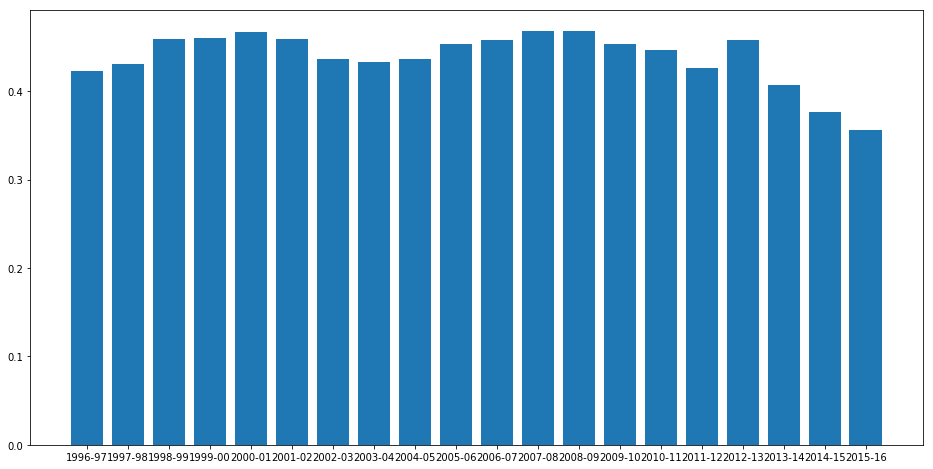

In [160]:
feature_name='season'
data = known_data
data[feature_name] = data[feature_name].astype('object')
data_features = data[feature_name];
data_features = pd.unique(data_features)
#print(data_features)
hit_rate = np.zeros((data_features.shape[0],1),dtype=np.float32)
i = 0
for type in data_features:
    sub_type = data.loc[data[feature_name] == type]
    nb_success_hit = sub_type.loc[sub_type['shot_made_flag'] == 1]
    nb_success_hit = nb_success_hit.shape[0]
    nb_fail_hit = sub_type.loc[sub_type['shot_made_flag'] == 0]
    nb_fail_hit = nb_fail_hit.shape[0]
    hit_rate[i] = nb_success_hit/(nb_success_hit+nb_fail_hit)
    i = i+1
hit_rate = hit_rate.reshape(-1)
plt.figure(figsize=(16,8))    
plt.bar(data_features,hit_rate)
plt.show()

In [161]:
import math
import operator
def sort_and_partition(data, name, n):
    stat = {}
    for i, (d, x) in enumerate(zip(data[name], data['shot_made_flag'])):
        if not (d in stat) :
            stat[d] = [0, 0]
        if x == 1:
            stat[d][0] += 1
            stat[d][1] += 1
        else:
            stat[d][1] += 1
    for key, value in stat.items():
        stat[key] = value[0] / value[1]
    stat = sorted(stat.items(), key=operator.itemgetter(1))
    index_map = {}
    for i, (key, value) in enumerate(stat):
        index_map[key] = math.floor(i / n)
    length = math.ceil(len(stat) / n)
    da = {}
    zeros = [0 for i in range(length)]
    for i in range(length):
        da[name + str(i)] = []
    for i, l in enumerate(data[name]):
        for j in range(length):
            if j == index_map[l]:
                da[name + str(j)].append(1)
            else:
                da[name + str(j)].append(0)
    return pd.DataFrame(data = da)

# Data pre-processing and features selections

In [162]:
from sklearn import preprocessing

## Decide the training set
data = final_complete_data
X = data[[#u'lat', 
          #u'lon', 
          u'shot_distance',
          u'playoffs',
          u'loc_x',
          u'loc_y'
         ]]

## Quantization of features
mins = sort_and_partition(data, 'minutes_remaining', 3)
seasons = sort_and_partition(data, 'season', 1)
seconds = sort_and_partition(data, 'seconds_remaining', 10)
opponent = sort_and_partition(data, 'opponent', 3)

## dummy coded features
dummy_action_type = pd.get_dummies(data[[u'action_type']])
dummy_combined_shot_type = pd.get_dummies(data[[u'combined_shot_type']])
dummy_period = pd.get_dummies(data[[u'period']])      
dummy_playoffs = pd.get_dummies(data[[u'playoffs']])
dummy_opponent = pd.get_dummies(data[[u'opponent']])
dummy_season = pd.get_dummies(data[[u'season']])
dummy_shot_type = pd.get_dummies(data[[u'shot_type']])
dummy_shot_zone_area = pd.get_dummies(data[[u'shot_zone_area']])
dummy_shot_zone_basic = pd.get_dummies(data[[u'shot_zone_basic']])
dummy_home_feild = pd.get_dummies(data[[u'home_field']])

#Final Features
X = pd.concat([X, \
               mins, \
               seconds,\
               seasons,\
               opponent,\
               dummy_home_feild,\
               dummy_action_type,\
               #dummy_combined_shot_type,\
               dummy_period,\
               dummy_shot_type,\
               dummy_shot_zone_area,\
               dummy_shot_zone_basic], axis = 1)
X_train = X.tail(30697-5000)
X_test = X.head(5000)
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

#Scaling (Performance is not good)
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)

#Dependent
y = data[[u'shot_made_flag']]
y_train = y.tail(30697-5000)
y_test = y.head(5000)
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

#Print Shapoe
print(X_train.shape)
print(X_test.shape)



(25697, 119)
(5000, 119)


# Logistic Regression

In [163]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)

LR = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
                        intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
                        max_iter=10000, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
LR.fit(X_train,y_train)
y_predict_proba_LR = LR.predict_proba(X_test)
score_test = log_loss(y_test, y_predict_proba_LR[:,1])
y_predict_proba_LR_train = LR.predict_proba(X_train)
score_training= log_loss(y_train, y_predict_proba_LR_train[:,1])
print('Log loss train: %f' %score_training)
print('Log loss test: %f' %score_test)

Log loss train: 0.604325
Log loss test: 0.608044


# K-Fold LR (Deprecated)

In [165]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.model_selection import KFold

n_folds = 6
kf = KFold(n_folds)
kf.get_n_splits(X_all)
logloss = np.zeros((1,n_folds),dtype=np.double)
for k, (train, test) in enumerate(kf.split(X_train,y_train)):
     LR = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
                         intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
                         max_iter=10000, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
     LR.fit(X_train[train],y_train[train])
     y_predict_proba_LR_kfold = LR.predict_proba(X_train[test])
     logloss[0][k] = log_loss(y_train[test], y_predict_proba_LR_kfold[:,1])
print('Log loss: %f' %np.mean(logloss))

Log loss: 0.610125


# Decision Tree

In [166]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

print('Decision tree with gini criterion')
clf_gini = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 2)
clf_gini.fit(X_train, y_train)
y_predict_proba_clf_gini = clf_gini.predict_proba(X_test)
score = log_loss(y_test, y_predict_proba_clf_gini[:,1]) 
print('Log loss: %f' %score)

print('Decision tree with entropy criterion')
clf_entropy = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
clf_entropy.fit(X_train, y_train)
y_predict_proba_clf_entropy = clf_entropy.predict_proba(X_test)
score = log_loss(y_test, y_predict_proba_clf_entropy[:,1]) 
print('Log loss: %f' %score)


Decision tree with gini criterion
Log loss: 0.626109
Decision tree with entropy criterion
Log loss: 0.626109


# Random Forest

In [12]:
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)

RFC = RandomForestClassifier()
parameters_RFC = {'n_estimators':[100],'criterion':['entropy'],'random_state':[42]}
grid_search_RFC = GridSearchCV(RFC, parameters_RFC)                             
grid_search_RFC.fit(X_train,y_train)
best_n_estimators_RFC = grid_search_RFC.best_params_['n_estimators']
best_criterion_RFC = grid_search_RFC.best_params_['criterion']

RFC_Best = RandomForestClassifier(n_estimators=best_n_estimators_RFC, criterion=best_criterion_RFC, random_state=42)
RFC_Best.fit(X_train,y_train)
y_predict_proba_RFC = RFC_Best.predict_proba(X_test)
accuracy_score_RFC = accuracy_score(y_test, RFC_Best.predict(X_test))
roc_auc_score_RFC = roc_auc_score(y_test, y_predict_proba_RFC[:,1])
score = log_loss(y_test, y_predict_proba_RFC[:,1])

#print('The best parameter \'n_estimators\' is: %d' %best_n_estimators_RFC)
#print('The best parameter \'criterion\' is: %s' %best_criterion_RFC)
#print('The testing accuracy (accuracy_score) is: %f' %accuracy_score_RFC)
print('The roc_auc_score is: %f' %roc_auc_score_RFC)
print('Logloss: %f' %score)

The best parameter 'n_estimators' is: 200
The best parameter 'criterion' is: entropy
The testing accuracy (accuracy_score) is: 0.662646
The roc_auc_score is: 0.689162
Logloss: 0.656114


# XGBoost

In [167]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.model_selection import GridSearchCV

# parameters = {'n_estimators':[200],\
#               'learning_rate':[0.03],\
#               'max_depth':[6],\
#              }
# XGB = XGBClassifier(num_class=2,objective='multi:softprob')
# grid_search_XGB = GridSearchCV(XGB, parameters)                             
# grid_search_XGB.fit(X_train,y_train)
# best_n_estimators_XGB = grid_search_XGB.best_params_['n_estimators']
# best_learning_rate_XGB = grid_search_XGB.best_params_['learning_rate']
# best_max_depth_XGB = grid_search_XGB.best_params_['max_depth']

# XGB_Best = XGBClassifier(n_estimators=best_n_estimators_XGB,\
#                           learning_rate=best_learning_rate_XGB,\
#                      num_class=2,\
#                      min_child_weight = 9,\
#                      max_depth=best_max_depth_XGB,\
#                      objective='multi:softprob')

XGB_Best = XGBClassifier(n_estimators=200,\
                         learning_rate=0.033,\
                         num_class=2,\
                         min_child_weight = 9,\
                         max_depth=7,\
                         objective='multi:softprob')

XGB_Best.fit(X_train,y_train)
y_predict_proba_XGB = XGB_Best.predict_proba(X_test)
accuracy_score_XGB = accuracy_score(y_test, XGB_Best.predict(X_test))
roc_auc_score_XGB = roc_auc_score(y_test, y_predict_proba_XGB[:,1])
score = log_loss(y_test, y_predict_proba_XGB[:,1])
print('Log loss: %f' %score)

Log loss: 0.607497


# KFolk XBoost (Deprecated)

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import log_loss
# from sklearn.model_selection import KFold
# from xgboost import XGBClassifier

# n_folds = 6
# kf = KFold(n_folds)
# kf.get_n_splits(X_all)
# logloss = np.zeros((1,n_folds),dtype=np.double)
# for k, (train, test) in enumerate(kf.split(X_train,y_train)):
#     XGB_Best = XGBClassifier(n_estimators=100,\
#                              learning_rate=0.04,\
#                              num_class=2,\
#                              min_child_weight = 9,\
#                              max_depth=7,\
#                              objective='multi:softprob')
#     XGB_Best.fit(X_train[train],y_train[train])
#     y_predict_proba_XGB_kfold = XGB_Best.predict_proba(X_train[test])
#     logloss[0][k] = log_loss(y_train[test], y_predict_proba_XGB_kfold[:,1])
# print('Log loss: %f' %np.mean(logloss))